<a href="https://colab.research.google.com/github/getokyes/CodTech-Internship/blob/main/Task1_PySpark_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark findspark


In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, max, min, to_date


In [3]:
spark = SparkSession.builder \
    .appName("BrazilianEcommerceAnalysis") \
    .getOrCreate()


In [4]:
orders = spark.read.csv("/content/olist_orders_dataset.csv", header=True, inferSchema=True)
customers = spark.read.csv("/content/olist_customers_dataset.csv", header=True, inferSchema=True)
order_items = spark.read.csv("/content/olist_order_items_dataset.csv", header=True, inferSchema=True)
products = spark.read.csv("/content/olist_products_dataset.csv", header=True, inferSchema=True)
sellers = spark.read.csv("/content/olist_sellers_dataset.csv", header=True, inferSchema=True)
order_payments = spark.read.csv("/content/olist_order_payments_dataset.csv", header=True, inferSchema=True)
order_reviews = spark.read.csv("/content/olist_order_reviews_dataset.csv", header=True, inferSchema=True)
geolocation = spark.read.csv("/content/olist_geolocation_dataset.csv", header=True, inferSchema=True)


In [5]:
orders.printSchema()
orders.show(5)
print(f"Number of orders: {orders.count()}")


root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------

BASIC DATA CLEANING

In [6]:
orders = orders.withColumn("order_purchase_date", to_date(col("order_purchase_timestamp")))


In [7]:
orders = orders.dropna(subset=["order_id"])
orders = orders.dropDuplicates(["order_id"])


ANALYSIS

In [8]:
orders.groupBy("order_status") \
      .count() \
      .orderBy(col("count").desc()) \
      .show()


+------------+-----+
|order_status|count|
+------------+-----+
|   delivered|96478|
|     shipped| 1107|
|    canceled|  625|
| unavailable|  609|
|    invoiced|  314|
|  processing|  301|
|     created|    5|
|    approved|    2|
+------------+-----+



In [9]:
from pyspark.sql.functions import datediff

orders = orders.withColumn("delivery_days",
                           datediff(col("order_delivered_customer_date"),
                                    col("order_purchase_timestamp")))

orders.groupBy().avg("delivery_days").show()


+------------------+
|avg(delivery_days)|
+------------------+
|12.497336125046644|
+------------------+



In [10]:
orders.join(customers, "customer_id") \
      .groupBy("customer_city") \
      .count() \
      .orderBy(col("count").desc()) \
      .show(5)


+--------------+-----+
| customer_city|count|
+--------------+-----+
|     sao paulo|15540|
|rio de janeiro| 6882|
|belo horizonte| 2773|
|      brasilia| 2131|
|      curitiba| 1521|
+--------------+-----+
only showing top 5 rows



In [11]:
order_items.groupBy().sum("price", "freight_value").show()


+-------------------+------------------+
|         sum(price)|sum(freight_value)|
+-------------------+------------------+
|1.359164370000748E7| 2251909.540000007|
+-------------------+------------------+



In [12]:
orders.write.mode("overwrite").parquet("processed_orders/")


In [13]:
order_items.join(products, "product_id") \
           .groupBy("product_category_name") \
           .count() \
           .orderBy(col("count").desc()) \
           .show(10)


+---------------------+-----+
|product_category_name|count|
+---------------------+-----+
|      cama_mesa_banho|11115|
|         beleza_saude| 9670|
|        esporte_lazer| 8641|
|     moveis_decoracao| 8334|
| informatica_acess...| 7827|
| utilidades_domest...| 6964|
|   relogios_presentes| 5991|
|            telefonia| 4545|
|   ferramentas_jardim| 4347|
|           automotivo| 4235|
+---------------------+-----+
only showing top 10 rows



In [14]:
order_reviews.groupBy("review_score") \
             .count() \
             .orderBy(col("review_score")) \
             .show()


+--------------------+-----+
|        review_score|count|
+--------------------+-----+
|                NULL| 2380|
|                   "|    1|
| BARALHO KEM COM ...|    1|
|       Desta vez nã"|    1|
|                   M|    1|
| NAO confere para...|    1|
| VOU RECEBER DEPO...|    1|
| a URA não resolv...|    1|
| a previsão dada ...|    1|
| a pulseira do me...|    1|
|  achei muito cara."|    1|
| acho que vi duas...|    1|
| adorou o novo ""...|    1|
| agora me pergunt...|    1|
| ainda resta um p...|    1|
| alias comprei ju...|    1|
| até agora só inf...|    1|
|      até antecipado|    1|
| até o presente n...|    1|
|            azar..."|    1|
+--------------------+-----+
only showing top 20 rows



In [15]:
delivery_reviews = orders.join(order_reviews, "order_id") \
                         .select("delivery_days", "review_score")

delivery_reviews.groupBy("review_score") \
                .agg(avg("delivery_days").alias("avg_delivery_days")) \
                .orderBy("review_score") \
                .show()


+------------+------------------+
|review_score| avg_delivery_days|
+------------+------------------+
|           1|21.251886491656926|
|           2|  16.6059163549813|
|           3|14.204345641798543|
|           4| 12.25312055617001|
|           5|10.625359270942868|
+------------+------------------+



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots prettier
sns.set(style="whitegrid", palette="muted", font_scale=1.2)


/tmp/ipython-input-911150378.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="order_status", y="count", data=order_status_df, palette="viridis")


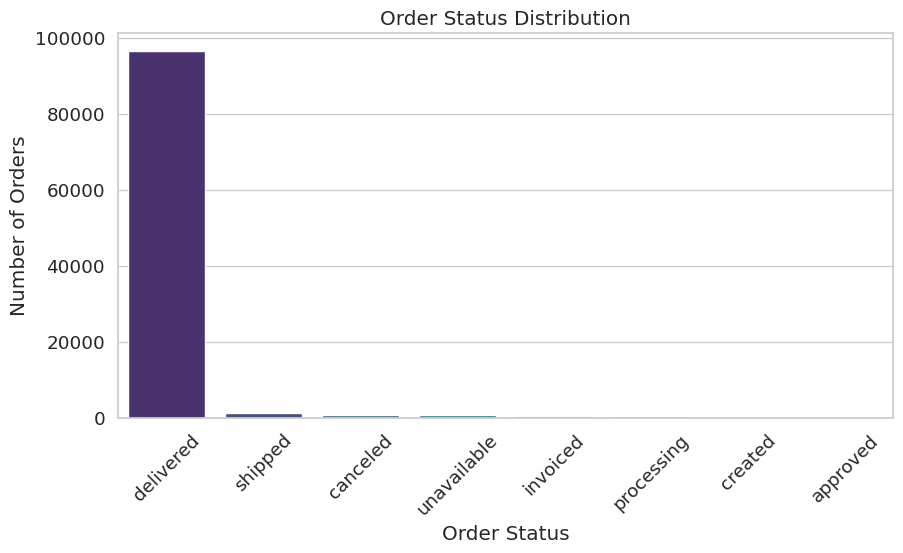

In [17]:
order_status_df = orders.groupBy("order_status") \
                        .count() \
                        .orderBy(col("count").desc()) \
                        .toPandas()

plt.figure(figsize=(10,5))
sns.barplot(x="order_status", y="count", data=order_status_df, palette="viridis")
plt.title("Order Status Distribution")
plt.xlabel("Order Status")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-1671250849.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="customer_city", x="count", data=top_cities_df, palette="coolwarm")


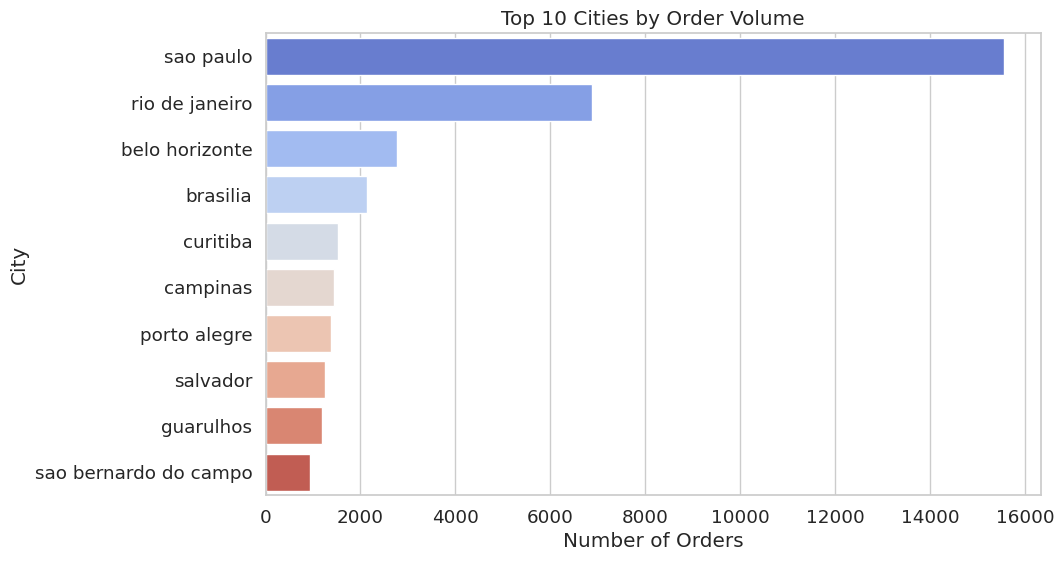

In [19]:
top_cities_df = orders.join(customers, "customer_id") \
                      .groupBy("customer_city") \
                      .count() \
                      .orderBy(col("count").desc()) \
                      .limit(10) \
                      .toPandas()

plt.figure(figsize=(10,6))
sns.barplot(y="customer_city", x="count", data=top_cities_df, palette="coolwarm")
plt.title("Top 10 Cities by Order Volume")
plt.xlabel("Number of Orders")
plt.ylabel("City")
plt.show()


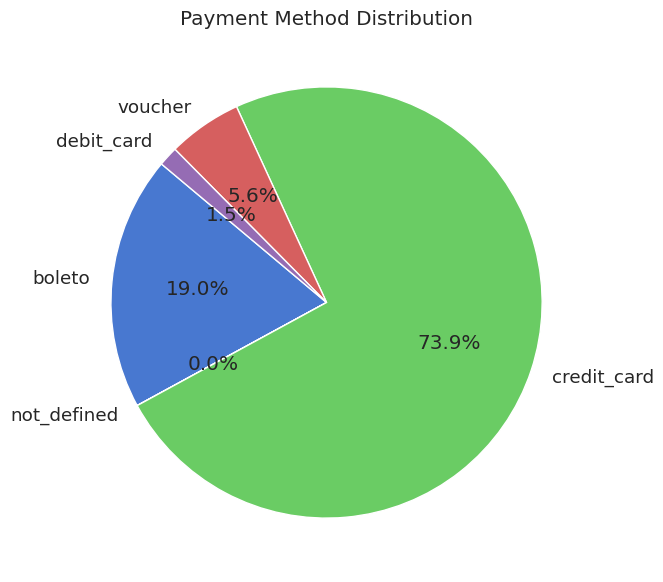

In [20]:
payment_df = order_payments.groupBy("payment_type") \
                           .count() \
                           .toPandas()

plt.figure(figsize=(7,7))
plt.pie(payment_df['count'], labels=payment_df['payment_type'], autopct='%1.1f%%', startangle=140)
plt.title("Payment Method Distribution")
plt.show()


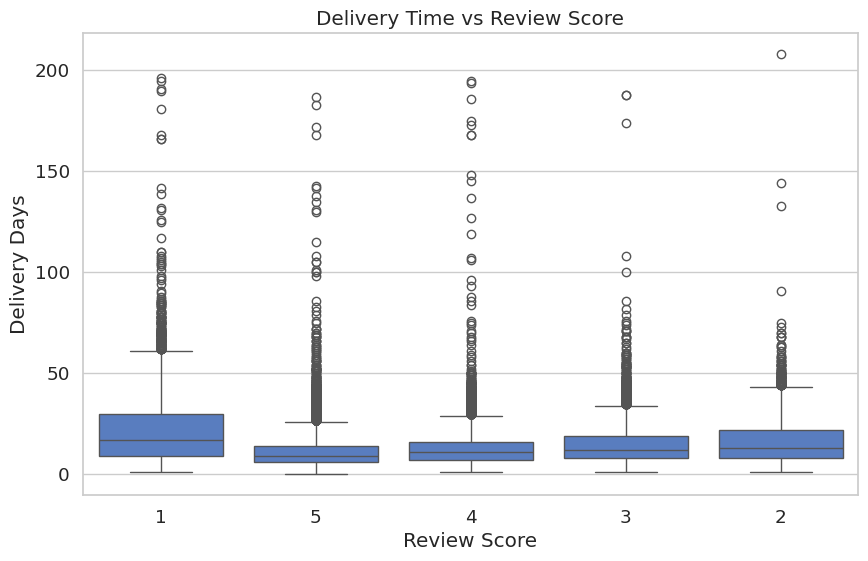

In [21]:
delivery_reviews_df = orders.join(order_reviews, "order_id") \
                            .select("delivery_days", "review_score") \
                            .dropna() \
                            .toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="review_score", y="delivery_days", data=delivery_reviews_df)
plt.title("Delivery Time vs Review Score")
plt.xlabel("Review Score")
plt.ylabel("Delivery Days")
plt.show()
